In [1]:
import os
os.chdir('../')
# esse comando é melhor do que sys.path.insert(0, '../') pois permite interagir com arquivos do diretorio acima

In [2]:
import pickle
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
import seaborn as sns
pd.set_option('display.max_rows', 167) # opcional, questão de visualização para debugar caso 1

In [3]:
from pynnystock.FileManager import FileManager
from pynnystock.Ativo import Ativo
# from pynnystock.Parameters import Parameters
# from pynnystock.StatsGatherer import StatsGatherer
# from pynnystock.StratsMaestro import StratsMaestro
from pynnystock.Simulator import Simulator
from pynnystock.BootstrapSimulator import BootstrapSimulator
# from pynnystock.OptimizerSimulator import OptimizerSimulator

In [4]:
from pynnystock.strategies.doubleentriesdoublestops.ParametersDEDS import ParametersDEDS
from pynnystock.strategies.doubleentriesdoublestops.StatsGathererDEDS import StatsGathererDEDS
from pynnystock.strategies.doubleentriesdoublestops.StratsMaestroDEDS import StratsMaestroDEDS
from pynnystock.strategies.doubleentriesdoublestops.OptimizerSimulatorDEDS import OptimizerSimulatorDEDS

In [5]:
fm = FileManager()

In [6]:
pars = ParametersDEDS()

In [7]:
sg = StatsGathererDEDS(pars)

##### Na primeira vez precisa gerar o pickle de ativo_dia_list.pkl
##### Somente executar esse código se o pickle ativo_dia_list.pkl não tiver sido gerado

In [ ]:
# abre arquivo com freefloats
names_pennystocks = fm.getNames()
names_free_float = fm.getFreeFloatNames()
names = list(set(names_pennystocks) & set(names_free_float))
names.sort()

In [ ]:
# gera ativo_dia_list (adl), que é uma lista com resumo dos dias que vai nos auxiliar a filtrar os dias de interesse
# também vai auxiliar na análise de ativos-dia
adl = []
for n in names[0:10]:
#for n in names:
    print(n)
    try:
        a = Ativo(n, fm[n], sg)
        for intraday in a.intraDays:
            d = {'name': a.name,
                 'date': intraday.date,
                 'freefloat': fm.getFreeFloat(n),
                 'stats': intraday.stats}
            adl.append( d )
    except IndexError:
        print("Ativo sem nenhum dado ou dado inconsistente")

In [ ]:
with open('AtivoDiaList.pkl', 'wb') as filehandle: # w de write e b de binary
    pickle.dump(adl,filehandle)

##### Com o pickle ativo_dia_list.pkl gerado, prosseguir daqui

In [8]:
with open('AtivoDiaList.pkl', 'rb') as filehandle:
    ativo_dia_list = pickle.load(filehandle)

In [9]:
sm = StratsMaestroDEDS(pars)

In [10]:
sim = Simulator(fm,ativo_dia_list,pars,sm,sg)

In [11]:
bss = BootstrapSimulator(sg)

In [12]:
os = OptimizerSimulatorDEDS(sim, bss, sg)

In [13]:
# pars.setFilterParameters(gap_threshold=0.1, F_high_threshold=9)
pars.setFilterParameters(prevol_threshold=15000000)
sim.runFiltering()

In [14]:
# pars.setSimParameters(start_money = 10000,allocation=0.1)
# pars.setAlgoParameters(short_after=0, exit_target=0.4, exit_stop=0.4)
# pars.setAlgoParameters(short_after=0.2)

sim.runSimulation()

#sim.saveTrades('case1_trades.pkl')
# sim.openTrades('case1_trades.pkl')

In [15]:
dfd = sg.filtereddf # DataFrame of filtered ativo-dias
dft = sg.tradesdf # DataFrame of trades
dfes = sg.extrastatsdf # DataFrame of extra statistics

##### Algumas análises da simulação

In [16]:
sg.printSimResults()


PARÂMETROS PARA ALGORITMO DO TIPO DOUBLE ENTRY DOUBLE STOP
FILTERING PARAMETERS
prevol_threshold: 15000000
open_dolar_threshold: 2
gap_threshold: 0.2
F_low_threshold: 0
F_high_threshold: 1

TRADING PARAMETERS
short_after1: 0
short_after2: 0.1
firstEntryPct: 0.5
exit_target: 0.3
exit_stop: 0.3

SIMULATION PARAMETERS
start_money: 10000
allocation: 0.1
locate_fee: 0.02
commission: 2

Start Money: $10,000.00
End Money: $12,500.60
Number of Trades: 22
Number of filtered ativo-dias: 22
Max Drawdown: 0.03217572413416314


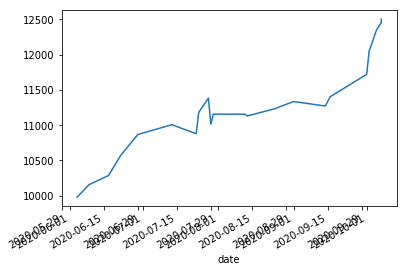

In [17]:
sg.plotEquityCurve()

##### Análise de algumas estratificações

In [18]:
dftr = pd.merge(dft,dfd,how='inner',on=['name','date'])
dftr = dftr[['name','date','gap','factorF','profit']]
dftr

,name,date,gap,factorF,profit
0,CIDM,2020-06-04,2.343511,1.658049,-0.022500
1,IZEA,2020-06-09,0.856000,1.051235,0.209483
2,UONEK,2020-06-17,1.518519,6.526083,0.150000
3,SINT,2020-06-22,2.416573,1.794230,0.322500
4,BHTG,2020-06-29,1.395210,2.910233,0.322500
5,ECOR,2020-07-13,2.738095,2.751838,0.150000
6,MIST,2020-07-23,1.323353,6.343137,-0.093209
7,ABUS,2020-07-24,0.289197,1.868844,0.322500
8,KODK,2020-07-28,2.675573,4.115038,0.210822
9,KODK,2020-07-29,1.286600,12.788022,-0.277500


In [19]:
bins = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2]
gap = np.clip( dftr['gap'], bins[0], bins[-1] )
dftr.groupby(pd.cut(gap, bins)).agg(
    winrate=pd.NamedAgg(column='profit',aggfunc=lambda x: sum(x>=0)/(sum(x>=0) + sum(x<0)) ),
    lossrate=pd.NamedAgg(column='profit',aggfunc=lambda x: sum(x<0)/(sum(x>=0) + sum(x<0)) ),
    mean=pd.NamedAgg(column='profit',aggfunc=lambda x: x.mean()),
    mean_of_pos=pd.NamedAgg(column='profit',aggfunc=lambda x: x[x>=0].mean()),
    mean_of_neg=pd.NamedAgg(column='profit',aggfunc=lambda x: x[x<0].mean()),
    count=pd.NamedAgg(column='profit',aggfunc='count'),
    positives=pd.NamedAgg(column='profit',aggfunc=lambda x: sum(x>=0) ),
    negatives=pd.NamedAgg(column='profit',aggfunc=lambda x: sum(x<0) )
)

,winrate,lossrate,mean,mean_of_pos,mean_of_neg,count,positives,negatives
gap,,,,,,,,
"(0.2, 0.3]",1.000000,0.000000,0.171609,0.171609,NaN,2,2.0,0.0
"(0.3, 0.4]",0.000000,1.000000,-0.022500,NaN,-0.022500,1,0.0,1.0
"(0.4, 0.5]",1.000000,0.000000,0.111047,0.111047,NaN,2,2.0,0.0
"(0.5, 0.6]",1.000000,0.000000,0.128917,0.128917,NaN,2,2.0,0.0
"(0.6, 0.7]",1.000000,0.000000,0.058824,0.058824,NaN,1,1.0,0.0
"(0.7, 0.8]",1.000000,0.000000,0.150000,0.150000,NaN,1,1.0,0.0
"(0.8, 0.9]",1.000000,0.000000,0.209483,0.209483,NaN,1,1.0,0.0
"(0.9, 1.0]",NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
"(1.0, 1.1]",NaN,NaN,NaN,NaN,NaN,0,NaN,NaN


In [20]:
dftr.groupby(dftr['date'].dt.to_period('M')).agg(
    winrate=pd.NamedAgg(column='profit',aggfunc=lambda x: sum(x>=0)/(sum(x>=0) + sum(x<0)) ),
    lossrate=pd.NamedAgg(column='profit',aggfunc=lambda x: sum(x<0)/(sum(x>=0) + sum(x<0)) ),
    mean=pd.NamedAgg(column='profit',aggfunc=lambda x: x.mean()),
    mean_of_pos=pd.NamedAgg(column='profit',aggfunc=lambda x: x[x>=0].mean()),
    mean_of_neg=pd.NamedAgg(column='profit',aggfunc=lambda x: x[x<0].mean()),
    count=pd.NamedAgg(column='profit',aggfunc='count'),
    positives=pd.NamedAgg(column='profit',aggfunc=lambda x: sum(x>=0) ),
    negatives=pd.NamedAgg(column='profit',aggfunc=lambda x: sum(x<0) )
)

,winrate,lossrate,mean,mean_of_pos,mean_of_neg,count,positives,negatives
date,,,,,,,,
2020-06,0.800000,0.200000,0.196397,0.251121,-0.022500,5,4.0,1.0
2020-07,0.666667,0.333333,0.077102,0.208331,-0.185354,6,4.0,2.0
2020-08,0.666667,0.333333,0.036443,0.065914,-0.022500,3,2.0,1.0
2020-09,0.666667,0.333333,0.074298,0.128917,-0.034941,3,2.0,1.0
2020-10,1.000000,0.000000,0.220896,0.220896,NaN,5,5.0,0.0


##### Analisando o Dataframe com extra statistics

In [21]:
# aqui podemos fazer alguma análise, basta fazer inner join de dfes com os outros dataframes dfd, dft
dfes

,name,date,open_pre,high_pre,low_pre,close_pre,open_core,high_core,low_core,close_core
0,CIDM,2020-06-04,2.14,4.45,1.8700,4.39,4.38,6.00,3.15,3.5424
1,IZEA,2020-06-09,1.74,2.73,1.4300,2.32,2.32,2.59,1.75,2.0800
2,UONEK,2020-06-17,3.88,8.01,3.5600,6.78,6.80,6.84,2.38,2.6500
3,SINT,2020-06-22,1.10,3.70,1.1000,2.74,2.75,3.13,1.87,2.0200
4,BHTG,2020-06-29,1.84,4.20,1.8400,4.02,4.00,4.40,2.55,2.7450
5,ECOR,2020-07-13,1.36,3.38,1.3600,3.16,3.14,3.30,1.66,1.7900
6,MIST,2020-07-23,3.50,7.85,3.5000,7.78,7.76,9.99,6.45,8.9000
7,ABUS,2020-07-24,7.20,8.89,6.5500,7.98,7.98,9.02,4.77,4.9400
8,KODK,2020-07-28,2.80,9.74,2.8000,9.62,9.63,11.80,7.62,8.0600
9,KODK,2020-07-29,12.03,18.50,11.2200,18.44,18.43,60.00,17.50,33.2000


##### Rodando Bootstrap

In [22]:
bss.runBootstrap()

In [23]:
sg.printBootstrapResults()

Max Drawdown: 0.03217572413416314
Mean of max Drawdown: 0.033976893572333286
Max of max Drawdown: 0.04554437033744174
Min of max Drawdown: 0.03217572413416303


##### Códigos para rodar combinações de parâmetros e otimizar.

In [24]:
os.runSimulationGroup(
    prevol_threshold = [15000000],
    open_dolar_threshold=[2],
    gap_threshold=[0.2],
    F_low_threshold=[0],
    F_high_threshold=[1],
    short_after1 = [0, 0.1],
    short_after2 = [0.2, 0.3],
    firstEntryPct = [0.5],
    exit_target = [0.2],
    exit_stop = [0.3],
    start_money = [10000],
    allocation=[0.1],
    locate_fee=[0.02],
    commission=[2]
)

Simulando 4 combinações de parâmetros.
running another simulation. 15/01/2021 21:36:46
running another simulation. 15/01/2021 21:36:57
running another simulation. 15/01/2021 21:37:09


TypeError: 'NoneType' object is not subscriptable

In [ ]:
sg.groupResults

In [ ]:
# sg.saveGroupResults('teste1.pkl')
sg.appendGroupResults('teste1.pkl')
# sg.openGroupResults('teste1.pkl')

##### Descrição simulações já rodadas

##### Testes temporários em geral

In [ ]:
sim.trades

In [ ]:
t = sim.trades[0]
t